<h1>Importing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1)

<h2>Loading simulated dataset

In [2]:
X, Y = load_planar_dataset()

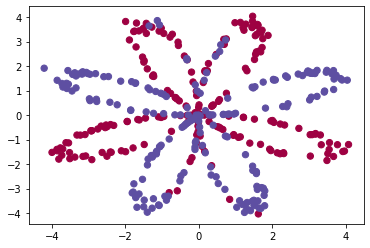

In [3]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [4]:
print ('the number of training set is : %d'%(X.size/X.shape[0]))

the number of training set is : 400


<h2>First attempt with logistic regression

In [5]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)

C:\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegressionCV()

In [6]:
clf.score(X.T, Y.T)

0.47

Text(0.5, 1.0, 'Logistic Regression')

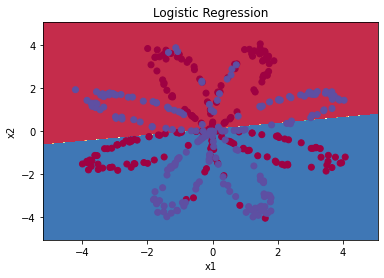

In [7]:
plot_decision_boundary(lambda x : clf.predict(x), X, Y)
plt.title('Logistic Regression')

In [8]:
LR_prediction = clf.predict(X.T)
print('The accuracy of model is %d ' %float((np.dot(Y, LR_prediction) + np.dot(Y - 1, LR_prediction - 1)) / Y.size * 100) + '%')

The accuracy of model is 47 %


<h3>As you can see logistic regression act poorly because our dataset has high degree polynomial nature

<h2>Lets try MLP

<h3>we have to implement a neural network using bare hands(only numpy)

In [9]:
def layer_size(X, Y):
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    return (n_x, n_h, n_y)

layer_size(X, Y)

<h3>now initializing parameters(weights and biases) for a two layer network

In [11]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(2)
    w1 = np.random.randn(n_h, n_x) * 0.01
    w2 = np.random.randn(n_y, n_h) * 0.01
    b1 = np.zeros((n_h, 1))
    b2 = np.zeros((n_y, 1))
    params = {"w1" : w1,
             "w2" : w2,
             "b1" : b1,
             "b2" : b2}
    return params

In [12]:
(n_x, n_h, n_y) = layer_size(X, Y)
params = initialize_parameters(n_x, n_h, n_y)
params

{'w1': array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
 'w2': array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
 'b1': array([[0.],
        [0.],
        [0.],
        [0.]]),
 'b2': array([[0.]])}

In [13]:
params["b2"].shape

(1, 1)

In [14]:
def forward_propagation(X, params):
    w1 = params['w1']
    w2= params['w2']
    b1= params['b1']
    b2=params['b2']
    z1 = np.dot(w1, X) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(w2, a1) + b2
    a2 = sigmoid(z2)
    cache = {           # parameters needed for back propagation
        "z1": z1,
        "a1": a1,
        "z2": z2,
        "a2": a2
    }
    return a2, cache

In [15]:
a2, cache = forward_propagation(X, params)
cache['a1']

array([[-0.00703166,  0.00017253,  0.00032324, ..., -0.00186491,
        -0.00016112, -0.004772  ],
       [ 0.03291681, -0.02769489, -0.02302533, ...,  0.02384144,
        -0.04161894,  0.03470405],
       [-0.05165672,  0.00962948,  0.00906554, ..., -0.01840864,
         0.01199586, -0.038914  ],
       [-0.03845703,  0.01925304,  0.01641664, ..., -0.02049136,
         0.02797832, -0.03452085]])

In [16]:
def compute_cost(Y, a2):
    m = Y.shape[1]
    cost = -1/m * (np.dot(Y, np.log(a2).T) + np.dot((1 - Y), np.log(1 - a2).T))
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    return cost

In [17]:
cost = compute_cost(Y, a2)

In [18]:
cost

0.6930480201239823

<h3>now compting derivatives

In [19]:
def back_propagation(cache, Y, params, X):
    w1 = params['w1']
    w2 = params['w2']
    b1 = params['b1']
    b2 = params['b2']
    #-----------------------
    z1 = cache['z1']
    z2 = cache['z2']
    a1 = cache['a1']
    a2 = cache['a2']
    #-----------------------
    m = X.shape[1]
    dz2 = a2 - Y
    dw2 = (1 / m) * np.dot(dz2, a1.T)
    db2 = (1 / m) * (np.sum(dz2, axis = 1, keepdims = True))
    dz1 = np.dot(w2.T, dz2) * (1 - np.power(a1, 2))
    dw1 = (1 / m) * (np.dot(dz1, X.T))
    db1 = (1 / m) * (np.sum(dz1, axis = 1, keepdims = True))
    grad = {
        'dw2': dw2,
        'dw1': dw1,
        'db2': db2,
        'db1': db1,
    }
    return grad

In [20]:
grad = back_propagation(cache, Y, params, X)

<h3>learning the correct parameters

In [21]:
def update_params(params, grad, learning_rate):
    w1 = params['w1']
    w2 = params['w2']
    b1 = params['b1']
    b2 = params['b2']
    #----------------
    dw1 = grad['dw1']
    db1 = grad['db1']
    dw2 = grad['dw2']
    db2 = grad['db2']
    #----------------
    w1 -= learning_rate * dw1
    w2 -= learning_rate * dw2
    b1 -= learning_rate * db1
    b2 -= learning_rate * db2
    u_params = {
        'w1': w1,
        'w2': w2,
        'b1': b1,
        
        'b2': b2
    }
    return u_params

In [22]:
update_params(params, grad, 0.005)

{'w1': array([[-0.00416876, -0.00055227],
        [-0.02136301,  0.01641162],
        [-0.01793375, -0.0084229 ],
        [ 0.00503139, -0.01247534]]),
 'w2': array([[-0.01057943, -0.00910859,  0.00552082,  0.02293487]]),
 'b1': array([[-5.34240152e-10],
        [ 4.85453626e-09],
        [ 3.60006329e-10],
        [-1.51524226e-09]]),
 'b2': array([[5.44615701e-08]])}

<h3>initializing the model

In [23]:
def nn_model(X, Y, n_h, learning_rate = 0.005, num_iteration = 10000, print_cost = True):
    n_x = layer_size(X, Y)[0]
    n_y = layer_size(X, Y)[2]
    params = initialize_parameters(n_x, n_h, n_y)
    w1 = params['w1']
    w2 = params['w2']
    b1 = params['b1']
    b2 = params['b2']
    for i in range(0, num_iteration):
        a2, cache = forward_propagation(X, params)
        cost = compute_cost(Y, a2)
        grad = back_propagation(cache, Y, params, X)
        params = update_params(params, grad, learning_rate)
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    return params

In [24]:
def predict(x, params):
    a2, cache = forward_propagation(x, params)
    return (a2 > 0.5)

<h3>as you see in next cell neural nets perform better in this dataset:)

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.292290
Cost after iteration 2000: 0.276357
Cost after iteration 3000: 0.240835
Cost after iteration 4000: 0.231060
Cost after iteration 5000: 0.226024
Cost after iteration 6000: 0.222677
Cost after iteration 7000: 0.220185
Cost after iteration 8000: 0.218208
Cost after iteration 9000: 0.216588


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

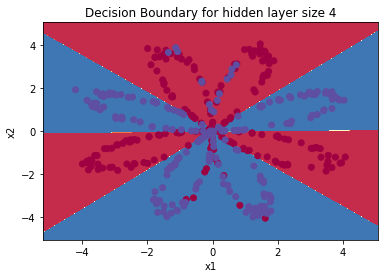

In [25]:
parameters = nn_model(X, Y, 4, 1, num_iteration = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(x.T, parameters), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [27]:
predictions = predict(X, parameters)
predictions

array([[False,  True,  True,  True, False,  True, False,  True, False,
        False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False,
      

In [59]:
predictions = np.where(predictions, 1, predictions)   # replacing boolean values with 0,1
predictions = np.squeeze(predictions)

In [60]:
# simple way to compute accuracy in binary classification
print("Accuracy: %f" % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100 )+ "%")

Accuracy: 90.750000%


Cost after iteration 0: 0.693148
Cost after iteration 1000: 0.636621
Cost after iteration 2000: 0.634757
Cost after iteration 3000: 0.633814
Cost after iteration 4000: 0.633205
Accuracy for 1 hidden units: 67.5 %
Cost after iteration 0: 0.693116
Cost after iteration 1000: 0.582325
Cost after iteration 2000: 0.578948
Cost after iteration 3000: 0.577291
Cost after iteration 4000: 0.576190
Accuracy for 2 hidden units: 67.25 %
Cost after iteration 0: 0.693114
Cost after iteration 1000: 0.285502
Cost after iteration 2000: 0.273063
Cost after iteration 3000: 0.266367
Cost after iteration 4000: 0.262067
Accuracy for 3 hidden units: 90.75 %
Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Accuracy for 4 hidden units: 90.5 %
Cost after iteration 0: 0.693252
Cost after iteration 1000: 0.283771
Cost after iteration 2000: 0.270689
Cost after iteration 3000: 0.263510
Cost 

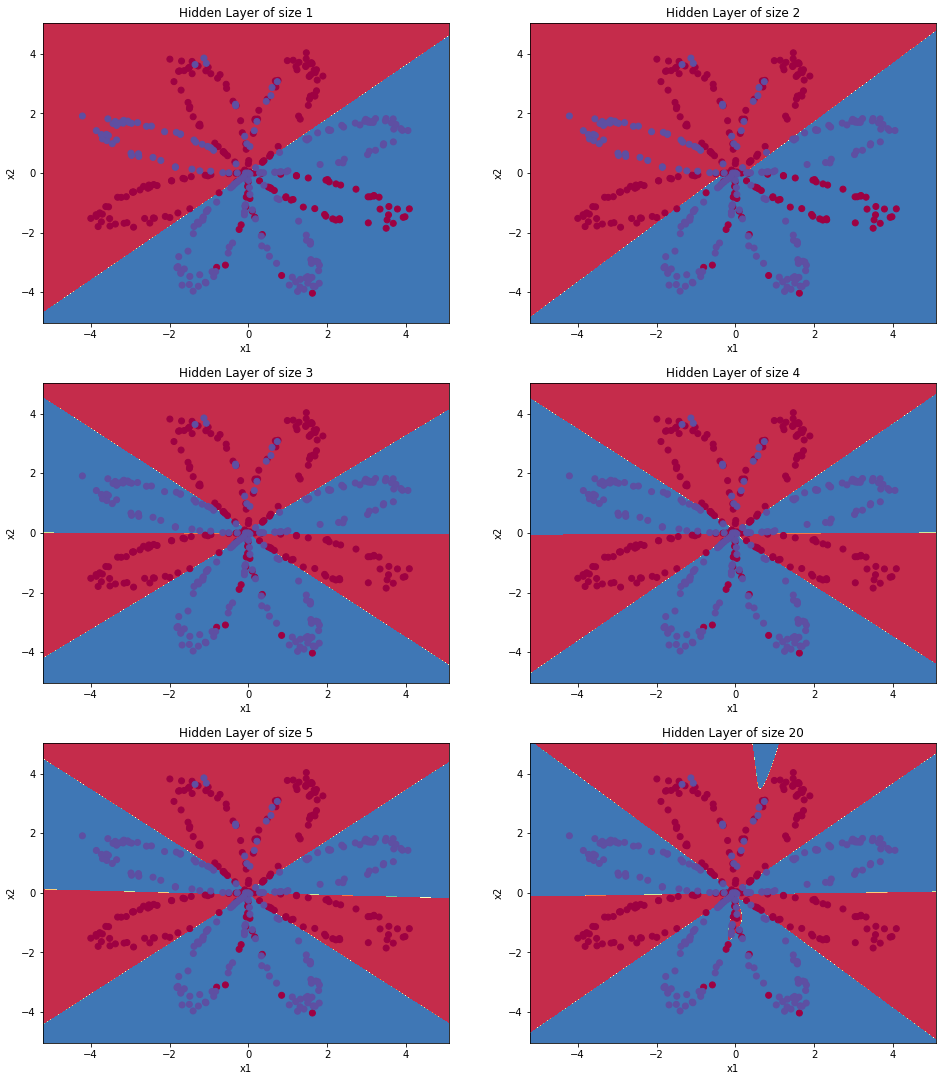

In [63]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h,1.2, num_iteration = 5000)
    plot_decision_boundary(lambda x: predict(x.T, parameters), X, Y)
    predictions = predict(X, parameters)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

<h3>as you can see this dataset has non-linear nature which MLP can learn well